In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from transformers import BertTokenizer, AutoModelForSequenceClassification, get_scheduler
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
pd.set_option('display.max_colwidth', 200)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


#### Config

In [ ]:
DATA_PATH = 'data/IMDB Dataset.csv'
SAVED_MODEL_PATH = '../model'
BERT_CHECKPOINT = 'google/bert_uncased_L-2_H-128_A-2' # bert-base-uncased(tiny)
MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10

### Load Data

In [ ]:
# Read data and remove duplicates
data = pd.read_csv(DATA_PATH).drop_duplicates()
print(f'Numbers of samples: {len(data)}')
data.head()

Numbers of samples: 49582


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


In [ ]:
# Transform sentiment to integers
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == "positive" else 0)
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",1
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",1
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",1
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,0
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",1


In [ ]:
# Train, validation and test splits
train_df, test_val_df = train_test_split(data, test_size = 0.2, stratify = data['sentiment'], random_state = 100)
val_df, test_df = train_test_split(test_val_df, test_size = 0.5, stratify = test_val_df['sentiment'], random_state = 100)
train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

print(f'Number of samples in train set: {len(train_df)}')
print(f'Number of samples in validation set: {len(val_df)}')
print(f'Number of samples in test set: {len(test_df)}')

Number of samples in train set: 39665
Number of samples in validation set: 4958
Number of samples in test set: 4959


In [ ]:
# Remove extra whitespaces and html tags
def clean_text(text):
    text = " ".join(text.split())
    text = re.sub(r'<.*?>', '', text)
    return text

In [ ]:
# Class for IMDB dataset
class IMDBDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len, clean_text = None):
        self.clean_text = clean_text
        self.review = review
        self.target = target
        self.tokenizer = tokenizer # BERT tokenizer
        self.max_len = max_len # Limit article length

    def __len__(self):
        return len(self.review)

    def __getitem__(self, idx):
        X = str(self.review[idx]) # Origin text
        y = torch.tensor(self.target[idx], dtype = torch.long) # Origin label
        if self.clean_text:
            X = self.clean_text(X)

        encoded_X = self.tokenizer(
            X,
            return_tensors = 'pt',
            max_length = self.max_len,
            truncation = True,
            padding = 'max_length'
        )

        return {'input_ids': encoded_X['input_ids'].squeeze(),
                'attention_mask': encoded_X['attention_mask'].squeeze(),
                'labels': y}

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_CHECKPOINT)

In [ ]:
dfs = {'train':train_df, 'val':val_df, 'test':test_df}
dataloaders = {}

for df in dfs:
    should_shuffle = True if df == 'train' else False
    dataloaders[df] = DataLoader(
    IMDBDataset(dfs[df]['review'],  dfs[df]['sentiment'], tokenizer = tokenizer, max_len = MAX_LEN, clean_text = clean_text),
    batch_size = BATCH_SIZE, shuffle = should_shuffle
    )

In [ ]:
# Testing if batch loads properly
for batch in dataloaders['train']:
    print({k:v.shape for k, v in batch.items()})
    break

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}


### Training

In [ ]:
# Model
model = AutoModelForSequenceClassification.from_pretrained(BERT_CHECKPOINT, num_labels = NUM_CLASSES) # Load BERT classification model
model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

# Scheduler
num_training_steps = NUM_EPOCHS * len(dataloaders['train'])
scheduler = get_scheduler(
    'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps
) # learn rate

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Test
outputs = model(**{k:v.to(device) for k, v in batch.items()})
print(outputs.loss, outputs.logits.shape)

tensor(0.7030, grad_fn=<NllLossBackward0>) torch.Size([32, 2])


In [ ]:
# Traing loop for one epoch
def train_epoch(model, dataloader, optimizer, scheduler, device, progress_bar):
    losses = []
    accuracies = []
    model.train()

    for batch in dataloader:
        optimizer.zero_grad()
        batch = {k:v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        preds = torch.argmax(outputs.logits, dim = 1)
        acc = torch.sum(preds == batch['labels']) / len(preds)
        accuracies.append(acc)
        losses.append(loss)
        progress_bar.update(1)

    return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()

In [ ]:
# Evaluation loop
def eval_epoch(model, dataloader, device):
    losses = []
    accuracies = []

    model.eval() # set to evaluation mode
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            preds = torch.argmax(outputs.logits, dim = 1)
            acc = torch.sum(preds == batch['labels']) / len(preds)
            accuracies.append(acc)
            losses.append(loss)

        return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()

In [ ]:
# Training, evaluation
progress_bar = tqdm(range(num_training_steps))
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc': []}

best_accuracy = 0
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, dataloaders['train'], optimizer, scheduler, device, progress_bar)
    print(f'Train Loss: {train_loss :.4f} | Accuracy: {train_acc*100 :.2f}')

    val_loss, val_acc = eval_epoch(model, dataloaders['val'], device)
    print(f'Eval Loss: {val_loss :.4f} | Accuracy: {val_acc*100 :.2f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # save best model
    if val_acc > best_accuracy:
        model.save_pretrained(SAVED_MODEL_PATH)
        best_accuracy = val_acc

    print('-'*50)

  0%|          | 0/12400 [00:00<?, ?it/s]

Train Loss: 0.5510 | Accuracy: 71.74
Eval Loss: 0.4327 | Accuracy: 80.28
--------------------------------------------------
Train Loss: 0.4191 | Accuracy: 81.14
Eval Loss: 0.3949 | Accuracy: 82.42
--------------------------------------------------
Train Loss: 0.3846 | Accuracy: 83.07
Eval Loss: 0.3815 | Accuracy: 82.90
--------------------------------------------------
Train Loss: 0.3574 | Accuracy: 84.45
Eval Loss: 0.3733 | Accuracy: 83.06
--------------------------------------------------
Train Loss: 0.3352 | Accuracy: 85.67
Eval Loss: 0.3793 | Accuracy: 82.78
--------------------------------------------------
Train Loss: 0.3178 | Accuracy: 86.67
Eval Loss: 0.3680 | Accuracy: 83.59
--------------------------------------------------
Train Loss: 0.3056 | Accuracy: 87.38
Eval Loss: 0.3675 | Accuracy: 83.91
--------------------------------------------------
Train Loss: 0.2949 | Accuracy: 87.77
Eval Loss: 0.3732 | Accuracy: 83.67
--------------------------------------------------
Train Lo

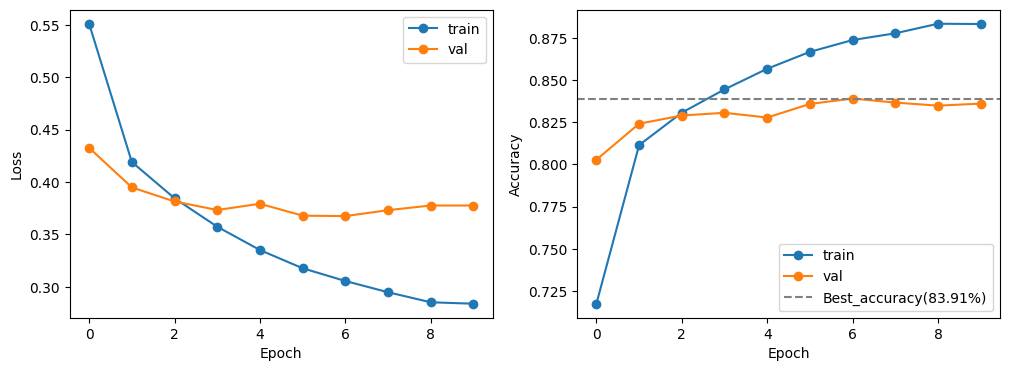

In [ ]:
# Plots
x_epochs = list(range(NUM_EPOCHS))
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, history['train_loss'], marker = 'o', label = 'train')
plt.plot(x_epochs, history['val_loss'], marker = 'o', label = 'val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, history['train_acc'], marker = 'o', label = 'train')
plt.plot(x_epochs, history['val_acc'], marker = 'o', label = 'val')
plt.axhline(best_accuracy, c = 'grey', ls = '--',
            label = f'Best_accuracy({best_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.show()

### Test

In [ ]:
# For final evaluation on test set
def test(model, dataloader, device):
    y_preds = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            y_preds.extend( torch.argmax(outputs.logits, dim = 1))
            y_true.extend( batch['labels'])
        return y_preds, y_true

In [ ]:
y_preds, y_true = test(model,dataloaders['test'], device)

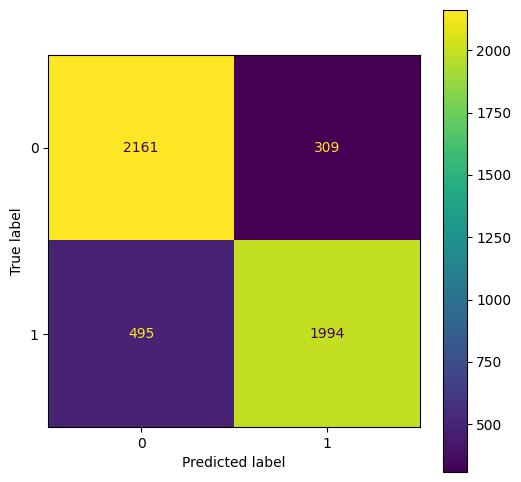

In [ ]:
_ , ax = plt.subplots(figsize = (6, 6))
ConfusionMatrixDisplay.from_predictions(torch.tensor(y_true), torch.tensor(y_preds), ax = ax, colorbar = True)
plt.savefig('ConfusionMatrix.jpg')

In [ ]:
print(classification_report(torch.tensor(y_true), torch.tensor(y_preds)))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2470
           1       0.87      0.80      0.83      2489

    accuracy                           0.84      4959
   macro avg       0.84      0.84      0.84      4959
weighted avg       0.84      0.84      0.84      4959



#### Inference

In [ ]:
# Load model config
import json
from transformers import BertConfig, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score


with open('BERT/model/config.json', 'r') as f:
  config_dict = json.load(f)

config = BertConfig.from_dict(config_dict)
model = BertForSequenceClassification(config)

In [ ]:
def tokenize_reviews(reviews, labels):
  input_ids = []
  attention_masks = []

  for review in reviews:
    encoded_dict = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=128,
        padding = 'max_length',
        truncation =True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim = 0)
  attention_masks = torch.cat(attention_masks, dim = 0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

In [ ]:
data = pd.read_csv(DATA_PATH).drop_duplicates()
data['review'] = data.apply(lambda x: clean_text(x['review']), axis = 1)
reviews = data['review'].to_numpy()
labels = data['sentiment'].map({'positive':1,'negative':0}).to_numpy()
x_train, x_test, y_train, y_test = train_test_split(reviews,labels, test_size = 0.2)
x_test = x_test[100:105]
y_test = y_test[100:105]

In [ ]:
inf_num = len(x_test)
inf_reviews = x_test
inf_labels = y_test
inf_inp_ids, inf_att_masks, inf_labels = tokenize_reviews(x_test, y_test)
inf_inp_ids, inf_att_masks, inf_labels = inf_inp_ids.to(device),inf_att_masks.to(device), inf_labels.to(device)

with torch.no_grad():
  inf_logits = model(inf_inp_ids, attention_mask=inf_att_masks)

for i in range(inf_num):
  print(f"""
  review: {inf_reviews[i]}
  predict: {inf_logits[0][i]}
  ground truth: {inf_labels[i]}
  -------------------------
  """)


  review: Unless you are already familiar with the pop stars who star in this film, save yourself the time and stop reading this review after you've reached the end of the next sentence.FORGET YOU EVER STUMBLED UPON THIS FILM AND GO WATCH SOMETHING ELSE.But if you insist on reading, consider: Lame vehicle for Japanese teen idol pretty-boys featuring nonsensical, convoluted "plot" that drags out for an insufferable amount of time until you're ready to scream.Nothing in this film makes sense. It's an endless series of people expressing various emotions, from joy to anger, from happiness to tragedy, FOR NO GOOD REASON. We can obviously see something incredibly "dramatic" is happening, but we just don't GIVE A CRAP WHY 'cause there's no backstory.By the time this film is over, you will be sick and tired of these stupid, lanky, girly stars' faces. You'll be revolted at having spent all this time watching them smile, sneer, cry, look mysterious, be "serious," and any other pointless express